In [203]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarQuery
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.mlab import griddata
import numpy as np
from scipy.stats import norm
import sfdmap
from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

In [55]:
# def findPrior(r,l,b):
#     l = np.linspace(0., 360., noStepsAngle)
#     xlen = (((r*np.cos(np.deg2rad(l)))-8))
#     ylen = ((r*np.sin(np.deg2rad(l))))
#     dist = ((xlen**2)+(ylen**2))**0. 

#     rogrim = 1
#     rtgrim = 1.9
#     rdgrim = 3.5
#     rzgrim = 0.41
#     rmgrim = 6.5
#     gamma = 1.8
#     bulge = 0.66
#     disc = 0.33

#     rowmv = ((bulge*((dist/rogrim)**gamma)*np.exp(-(dist**2/rtgrim**2)))+(disc*(np.exp((-rmgrim/dist)-(dist/rdgrim)))))
#     rowob = 
    
#     P = r**2*rowmw*rowob
#     return P

In [100]:
def newWeight(noSteps,fullPeriod,rM,satMag=5.7,limMag=21):
    bayestar = BayestarQuery(max_samples=2)
    ebv=[]
    ebv1d = []
    m = sfdmap.SFDMap('/home/mj1e16/DUST_DIR/sfddata-master/sfd')
    rogrim = 1.
    rtgrim = 1.9
    rdgrim = 3.5
    rzgrim = 0.41
    rmgrim = 6.5
    gamma = 1.8
    bulge = 0.66
    disc = 0.33
    q = 0.6
    distance = np.linspace(1,30.1,noSteps)
    
    
    number = 0
    l = np.linspace(0., 360., noSteps)
    b = np.linspace(0., 180., (noSteps/2))
    R = 2.273
    for z, bangle in enumerate(b):
        for i,x in enumerate(l):
            ebvPerD = []
            for d,dis in enumerate(distance):
                coords = SkyCoord(x*units.deg, bangle*units.deg,distance=(dis*1000)*units.pc, frame='galactic')
                ebvPerD.append(bayestar(coords, mode='median'))
            string = str(ebvPerD)
            if 'nan' in string:
                if number == 0:
                    startNan = i
                ebvPerD = []
                number += 1
                for d,dis in enumerate(distance):
                    angle = startNan-(x-startNan)
                    coords = SkyCoord(angle*units.deg, 0.*units.deg,distance=(dis*1000)*units.pc, frame='galactic')
                    ebvPerD.append(bayestar(coords, mode='median'))
            ebv.append(ebvPerD)

    mag = []
    #test = {}
    for y in range(len(l)):
        magperanlge = []
        for x,item in enumerate(distance): 
            magperanlge.append((5*np.log10((item*(1000/10)))+rM)+((ebv[y][x])*R))
            #test[d] = (5*np.log10((item*(1000/10)))+rM)+((ebv[y]+(item*0.53))*R)
        mag.append(magperanlge)
        
    totmag, totmaglist, brightProfile, brightProfilelist = [],[],[],[]
    xtotal, xlist, ytotal, ylist = [],[],[],[]
    Rd = 3 #kpc
    counter = 0
    othercounter = 0
    prior = []
    Prior = []
    anglesNew = []
    distNew = []
    brightProfilelist = []
    magProbs = []
    for z,bangle in enumberate(b):
        for x,angle in enumerate(l):        
            #prior = []
            smallDist = []
            smallAngle = []
            #xtotal = []
            #ytotal = []
            for y,item in enumerate(distance):
                dists = item*np.cos(np.deg2rad(bangle))
                xlen = (((dists*np.cos(np.deg2rad(l[x])))-8))
                ylen = ((dists*np.sin(np.deg2rad(l[x]))))
                z = item*np.cos(np.deg2rad(l[x]))
                if xlen**2+ylen**2 < 15**2:
                    xtotal.append(xlen)
                    ytotal.append(ylen)
                    totmaglist.append(mag[x][y])
                    dist = ((xlen**2)+(ylen**2))**0.5
                    smallDist.append(dist)
                    smallAngle.append(l)
                    #brightProfilelist.append(np.exp(-(dist/Rd)))
                    bp = (bulge*(((((dist**2)+((z**2)/(q**2)))**0.5)/rogrim)**-gamma)*np.exp(-(((dist**2)+((z**2)/(q**2)))/rtgrim**2)))+(disc*(np.exp((-rmgrim/dist)-(dist/rdgrim)-(abs(z)/rzgrim))))
                    brightProfilelist.append(bp)
                    othercounter += 1
                    if mag[x][y] > satMag and mag[x][y] < limMag:
                        magProb = 1
                    else:
                        magProb = 0
                    magProbs.append(magProb)
                    prior.append((item**2)*bp*magProb)
                

        xlist.append(xtotal)
        ylist.append(ytotal)
        totmag.append(totmaglist)
        anglesNew.append(smallAngle)
        distNew.append(distNew)
        brightProfile.append(brightProfilelist)
        #Prior.append(prior)
#     sumbp = sum(brightProfilelist)
#     summp = sum(magProbs)
#     normBp = [x/sumbp for x in brightProfilelist]
#     priorSum = sum(prior)
#     #Prior = [x for x in prior]
#     Prior = [x/(sumbp*sumbp) for x in prior]
#     #print(totmag)
#     print('xlist - ', xlist)
#     print('ylist - ', ylist)#
#     print('Prior - ', newPrior)
    #im = plt.pcolor(xlist,ylist,newPrior,cmap='plasma_r',vmin=0,vmax=1)
    def grid(x, y, z, resX=100, resY=100):
        "Convert 3 column data to matplotlib grid"
        xi = np.linspace(min(x), max(x), resX)
        yi = np.linspace(min(y), max(y), resY)
        Z = griddata(x, y, z, xi, yi,interp='linear')
        X, Y = np.meshgrid(xi, yi)
        return X, Y, Z

    X, Y, Z = grid(xtotal, ytotal, magProbs)#Prior)
    plt.contourf(X, Y, Z)
    plt.colorbar(label='Prior')
    plt.xlabel('Distance (kpc)')
    plt.ylabel('Distance (kpc)')
    plt.show()  
    im = plt.pcolor(X,Y,Z,cmap='plasma_r')
    plt.colorbar(im)
    plt.show()
    
    X, Y, Z = grid(xtotal, ytotal,Prior)
    plt.contourf(X, Y, Z)
    plt.colorbar(label='Prior')
    plt.xlabel('Distance (kpc)')
    plt.ylabel('Distance (kpc)')
    plt.show()  
    im = plt.pcolor(X,Y,Z,cmap='plasma_r')
    plt.colorbar(im)
    plt.show()
    
    return Prior

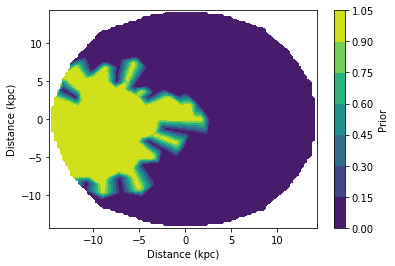

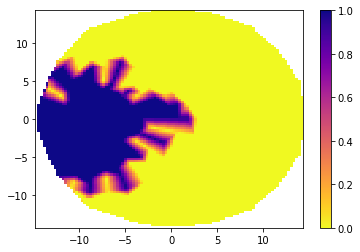

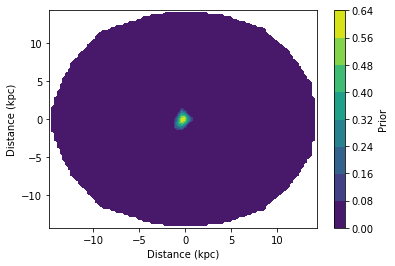

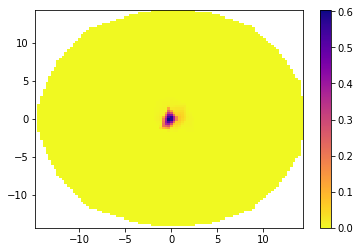

In [101]:
x = newWeight(31,0,3.5)

In [ ]:
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

X, Y, Z = grid(xlist[0], ylist[0], totmag[0])
plt.contourf(X, Y, Z)
plt.colorbar(label='Magnitude')
plt.xlabel('Distance (kpc)')
plt.ylabel('Distance (kpc)')
plt.show()


In [67]:
rogrim = 1.
rtgrim = 1.9
rdgrim = 3.5
rzgrim = 0.41
rmgrim = 6.5
gamma = 1.8
bulge = 0.66
disc = 0.33    
r = np.linspace(1,15,31)
bp = []
for x,dist in enumerate(r):
    bp.append((bulge*((dist/rogrim)**-gamma)*np.exp(-(dist**2/rtgrim**2)))+(disc*(np.exp((-rmgrim/dist)-(dist/rdgrim)))))
plt.plot(r,bp)
plt.show()
print(bp)

[0.50068464449674799, 0.1851227352067468, 0.078120100320084124, 0.038762198692922342, 0.025245928445631755, 0.021595130176382118, 0.021236244453265003, 0.021568173542618273, 0.021697912546357449, 0.02141868706526975, 0.020763116809774777, 0.019825460973024258, 0.018700245978287029, 0.017465627627557902, 0.016181684299789372, 0.014892807670250044, 0.013630753170083831, 0.012417413003802589, 0.01126712289982649, 0.010188516488799641, 0.0091859895106192278, 0.0082608419794365749, 0.0074121604720316179, 0.0066374936464834557, 0.0059333648683148965, 0.005295657476608007, 0.0047199010916148375, 0.0042014814625586962, 0.0037357915631272593, 0.0033183378024992161, 0.0029448121689112116]


In [24]:
l = np.linspace(0., 360., 61)
distance = np.linspace(0.1,30.1,61)
im = plt.pcolor(l,distance,newPrior,cmap='plasma_r',vmin=0,vmax=1)

ValueError: need more than 1 value to unpack

In [205]:
def newPrior(l,b,r):
    cumulative = []
    rogrim = 1.
    rtgrim = 1.9
    rdgrim = 3.5
    rzgrim = 0.41
    rmgrim = 6.5
    gamma = 1.8
    bulge = 2
    disc = 1
    sphere = 0.8
    Rc = 2.8
    q = 0.6
    b = 7.669
    satMag = 5.7
    limMag = 21
    brightProfilelist = []
    prior = []
    ebv = []
    bayestar = BayestarQuery(max_samples=2)
    rM = 3.5
    R = 3.1
    #R = 2.273
    for x,dis in enumerate(r):
        coords = SkyCoord(l*units.deg, b*units.deg,distance=(dis*1000)*units.pc, frame='galactic')
        ebv.append(bayestar(coords, mode='median'))
        string = str(ebv)
        if 'nan' in string:
            coords = SkyCoord((360-l)*units.deg, b*units.deg,distance=(dis*1000)*units.pc, frame='galactic')
            ebv.append(bayestar(coords, mode='median'))
            string = str(ebv)
            print('Oh Dear')
#             if number == 0:
#                 startNan = i
#             ebvPerD = []
#             number += 1
#             for d,dis in enumerate(r):
#                 angle = startNan-(x-startNan)
#                 coords = SkyCoord(angle*units.deg, 0.*units.deg,distance=(dis*1000)*units.pc, frame='galactic')
#                 ebvPerD.append(bayestar(coords, mode='median'))

    mag = []
    #test = {}
    magperanlge = []
    for x,item in enumerate(r): 
        mag.append((5*np.log10((item*(1000/10)))+rM)+((ebv[x])*R))
        #test[d] = (5*np.log10((item*(1000/10)))+rM)+((ebv[y]+(item*0.53))*R)
    #mag.append(magperanlge)
    
    for x,item in enumerate(r):
        #dists = item*np.cos(np.deg2rad(b))
        xlen = (((item*np.cos(np.deg2rad(l)))-8))*np.cos(np.deg2rad(b))
        ylen = ((item*np.sin(np.deg2rad(l))))*np.cos(np.deg2rad(b))
        z = item*np.cos(np.deg2rad(l))*np.sin(np.deg2rad(b))
        dist = ((xlen**2)+(ylen**2))**0.5
        R = ((dist**2)+(x**2))**0.5
        Bulge = (bulge*(((((dist**2)+((z**2)/(q**2)))**0.5)/rogrim)**-gamma)*np.exp(-(((dist**2)+((z**2)/(q**2)))/rtgrim**2)))
        Disc = (disc*(np.exp((-rmgrim/dist)-(dist/rdgrim)-(abs(z)/rzgrim))))
        Sphere = (sphere*(np.exp(-b*((R/Rc)**0.25))))/((R/Rc)**(7/8))
        #bp = (bulge*(((((dist**2)+((z**2)/(q**2)))**0.5)/rogrim)**-gamma)*np.exp(-(((dist**2)+((z**2)/(q**2)))/rtgrim**2)))+(disc*(np.exp((-rmgrim/dist)-(dist/rdgrim)-(abs(z)/rzgrim))))
        bp = Bulge + Disc + Sphere
        brightProfilelist.append(bp)
        if mag[x] > satMag and mag[x] < limMag:
            magProb = 1
        else:
            magProb = 0
        #magProbs.append(magProb)
        #print(bp)
        prior.append((x**2)*bp*magProb)
        if len(cumulative) != 0:
            cumulative.append((x**2)*bp*magProb+cumulative[-1])
        else:
            cumulative.append((x**2)*bp*magProb)
    #print(prior)
    maximus = max(prior)
    #print(r)
    #print(prior)
    print(len(cumulative))
    Cumulative = [x/cumulative[-1] for x in cumulative]
    prior = [(x/maximus) for x in prior]    
    plt.plot(r,prior)
    plt.xscale('log')
    plt.xlabel('kpc')
    plt.ylabel('Prior')
    plt.show()
    modeval = prior.index(max(prior))
    print(modeval)
    mode = r[modeval]
    print(mode)
    medianlist = [((0.5-x)**2) for x in cumulative]
    medianNo = (medianlist.index(min(medianlist)))
    print(medianNo)
    median = r[medianNo]
    print(median)
    plt.plot(r,Cumulative)
    plt.xscale('log')
    plt.xlabel('kpc')
    plt.ylabel('Prior')
    plt.show()
    DistList = [median,mode]
    return DistList

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


15


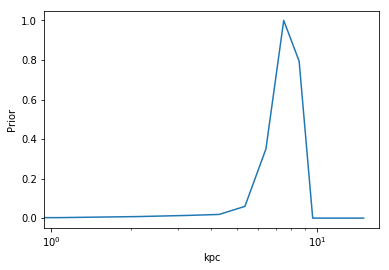

7
7.5
3
3.21428571429


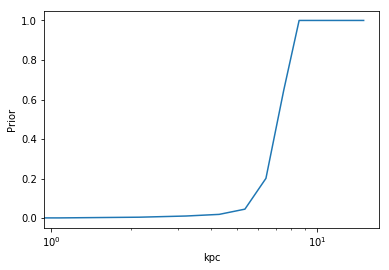

In [206]:
x = newPrior(0,0,np.linspace(0.0,15,15))

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


30


16
8.27586206897
3
1.55172413793


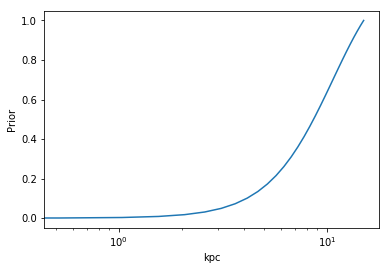

In [194]:
# d = 2.1
x = newPrior(071.3350,+03.0668,np.linspace(0.0,15,60)

In [182]:
r = np.linspace(0.0,15,15)

In [179]:
r[8]

8.5714285714285712

In [188]:
print(x[0],x[1])

2.06896551724 7.75862068966


In [200]:
coords = [['04 21 42.790', '+32 54 27.100'],
 ['06 22 44.500', '-00 20 44.720'],
 ['10 13 35.600', '-45 04 35.280'],
 ['11 18 10.790', '+48 02 12.420'],
 ['11 26 26.650', '-68 40 32.830'],
 ['13 57 16.820', '-09 32 38.550'],
 ['13 58 09.700', '-64 44 05.800'],
 ['15 47 08.320', '-47 40 10.800'],
 ['15 50 58.700', '-56 28 35.200'],
 ['16 50 00.980', '-49 57 43.600'],
 ['16 54 00.14', '-39 50 44.90'],
 ['16 59 01.680', '-15 15 28.730'],
 ['17 02 49.400', '-48 47 23.400'],
 ['17 08 15.520', '-25 05 30.150'],
 ['17 52 15.090', '-22 20 32.360'],
 ['17 53 28.290', '-01 27 06.220'],
 ['18 17 43.530', '-33 01 07.570'],
 ['18 19 21.580', '-25 24 25.100'],
 ['18 20 18', '+07 11 35'],
 ['18 58 41.580', '+22 39 29.400'],
 ['19 15 11.550', '+10 56 44.800'],
 ['19 58 21.67595', '+35 12 05.7783'],
 ['20 02 49.480', '+25 14 11.360'],
 ['20 24 03.820', '+33 52 01.900']]

In [201]:
distList = [2.49, 1.0599999, 3.8, 1.7, 5.9000001, 2.29, 25.0, 7.5, 4.5, 2.5999999, 3.2, 8.6000004, 6.0, 8.6000004, 6.0, 6.0, 5.5, 6.1999998, 0, 12.5, 9.0, 2.1, 2.7, 2.3900001]

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


60


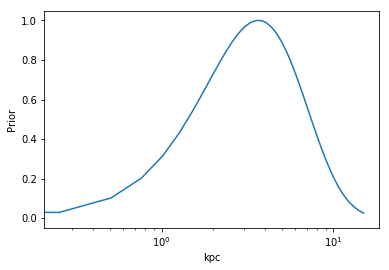

14
3.5593220339
3
0.762711864407


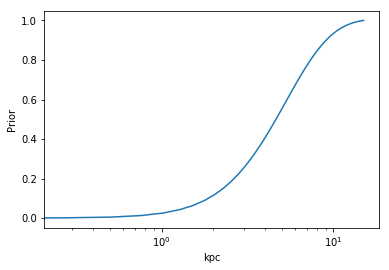

60


16
4.06779661017
3
0.762711864407


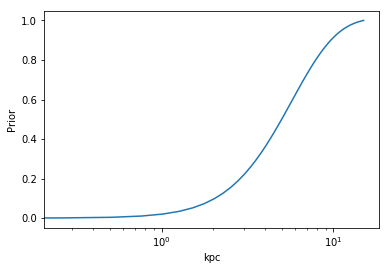

UnitsError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

In [207]:
gall = []
galb = []
for x in range(len(coords)):
    c = SkyCoord(coords[x][0]+coords[x][1], unit=(u.hourangle, u.deg))
    gal = c.galactic
    #galcoords.append(gal)
    gall.append(gal.l.deg)
    galb.append(gal.b.deg)
priors = []
for x in range(len(galb)):
    priors.append(newPrior(gall[x],galb[x],np.linspace(0.0,15,60)))

for x in range(priors):
    print('priors',priors[x],'distance',distList[x])
                